In this document I would like to go through some functional idioms in Python involving the use of iterators and highlight some parallels with the equivalent Haskell implementations.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import random, randint, choice
from itertools import cycle, ifilter, imap, islice, izip, starmap, tee
from collections import defaultdict
from operator import add, mul
from pymonad.Maybe import *
from pymonad.Reader import *

**The ubiquitous `zip`**

I must admit I severely underestimated the importance of `zip` when I first started learning functional style of programming. It comes up in a wide range of patterns, however one of the more elegant applications in Python is given in the following example:

In [2]:
a = range(0, 9)
zip(*[iter(a)]*4)

[(0, 1, 2, 3), (4, 5, 6, 7)]

In fact, it is mentioned in the [documentation](https://docs.python.org/2/library/functions.html#zip) in the section on built-in functions. I guess, it is one of those bits that are easily skipped on first reading. The reason this example works the way it does, namely, partitioning the iterable into chunks of the given length, is that `zip` evaluates its arguments strictly left-to-right. Hence, all the copies of the iterator get advanced together and dereferenced one by one.

Now we take a deeper dive straight away. Haskell introduces the [`zipWith`](https://www.haskell.org/hoogle/?hoogle=zipWith) function which takes an additional argument, a function which is applied to the corresponding elements of the zipped iterables. Thus the output is in general no longer a list of tuples of the original elements.
A possible implementation in Python is given below. Note that we return a generator so that the result can be evaluated lazily as needed.

In [3]:
def zip_with_(f, a, b):
     return (f(*z) for z in izip(a, b))

Another, more generic, implementation is possible using the [`starmap`](https://docs.python.org/2/library/itertools.html#itertools.starmap) function. 

In [4]:
def zip_with(f, *a):
    return starmap(f, izip(*a))

Using `zip_with` we can express operations on sequences in a more functional way:

In [5]:
b = range(10, 20)
list(zip_with(add, a, reversed(b)))

[19, 19, 19, 19, 19, 19, 19, 19, 19]

Before we proceed, let's introduce another bit of syntactical convenience:

In [6]:
@curry
def take(n, a):
    return islice(a, None, n)

@curry
def drop(n, a):
    return islice(a, n, None)

`@curry` will be explained later, for now just think of it as a fancy way of applying the idea behind [`functools.partial`](https://docs.python.org/2/library/functools.html#functools.partial) to forge partial application in Python.

I discovered some of the less obvious applications of `zipWith` while working on the exercises from the canonical [CIS194](http://www.seas.upenn.edu/~cis194/hw/01-intro.pdf) course on Haskell. For example, in order to multiply every other element of a sequence by, say 2, we can generate a "masking" sequenc of 1s and 2s and zip it with the original sequence via multiplication:

In [7]:
def double_every_other(a):
    return zip_with(mul, a, cycle([1,2]))

Lazy evaluation allows us to work with infinite lists without much trouble:

In [8]:
x = cycle([1, 2, 3])
take15 = take(15)
list(take15(x))

[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]

In [9]:
y = double_every_other(x)
list(take15(y))

[1, 4, 3, 2, 2, 6, 1, 4, 3, 2, 2, 6, 1, 4, 3]

In another amazing example which I first came across in a [SO answer](http://stackoverflow.com/questions/16378773/rotate-a-list-in-haskell/16379034#16379034) `zip` is used to rotate a (potentially empty or infinite) sequence. In order to emphasize the Haskell influence, let us first write it without all of the convenience functions defined above:

In [10]:
def rotate(n, a):
    return (x for x, _ in izip(islice(cycle(a), n , None), a))

In [11]:
h = "_hello_lazy_world"
r = rotate(6, h)
''.join(list(r))

'_lazy_world_hello'

Now we rewrite the same with more Haskell flavour:

In [12]:
def const(x, y):
    return x

def rotate1(n, a):
    return zip_with(const, drop(n, cycle(a)), a)

In [13]:
r1 = rotate1(6, h)
''.join(list(r1))

'_lazy_world_hello'

**Contextual iterators and monads**

Using a custom iterator for a class we can implement some fluent syntax for situations when operations on iterators need to be chained.

In [14]:
class Stream(object):
    
    def __init__(self, data):
        self.data = iter(data)
    
    def __iter__(self):
        class iterator(object):
            def __init__(self, it):
                self.it = it.data
            def next(self):
                return next(self.it)
        return iterator(self)
    
    def filter(self, pred):
        return Stream(ifilter(pred, self))
    
    def map(self, fn):
        return Stream(imap(fn, self))

In [15]:
s = Stream(range(20)). \
    filter(lambda x: x % 7 == 0). \
    map(lambda x: x * x)

In [16]:
list(s)

[0, 49, 196]

We may notice that the resulting flow has certain traits of a composable contextual computation - something that monads were introduced to deal with. Indeed, we start by putting the original data in a "streaming context". Each public method then extracts the actual data, applies some transformation and wraps it back into the context before passing on. This document is not going to descend into yet another tutorial on monads. Instead we will use the [`PyMonad`](https://pypi.python.org/pypi/PyMonad/) in a somewhat crude manner to demonstrate how the same goal can be achieved in a more functional way.
First we define a function that will wrap raw data in a context. If we were implementing our own monad, this would be the `unit`

In [17]:
def make_stream(data):
    try:
        return Just(iter(data))
    except TypeError:
        return Nothing

Now express the operations performed by the methods as monadic functions.

In [18]:
@curry
def filter_stream(pred, stream):
    return Just(ifilter(pred, stream))

@curry
def map_stream(fn, stream):
    return Just(imap(fn, stream))

At the end of the chain we will also need a way out of the context to continue working with the data. We do not intend to be 100% pure after all.

In [19]:
def eval_stream(stream):
    if isinstance(stream, Just):
        return stream.value
    else:
        return ()

Now we can also partially apply our function for better readability and potential reuse.

In [20]:
my_filter = filter_stream(lambda x: x % 7 == 0)
my_map = map_stream(lambda x: x * x)

Finally, execute the flow.

In [21]:
st = make_stream(range(20))
st1 = st >> my_filter >> my_map
list(eval_stream(st1))

[0, 49, 196]

We can take a different approach and work with ordinary functions instead:

In [22]:
@curry
def filter_stream1(pred, stream):
    return ifilter(pred, stream)

@curry
def map_stream1(fn, stream):
    return imap(fn, stream)

We can partially apply them, as before, and then use the overloaded `*` operator to denote curried function composition.

In [23]:
my_filter1 = filter_stream1(lambda x: x % 7 == 0)
my_map1 = map_stream1(lambda x: x * x)
my_transform = my_filter1 * my_map1

Finally the transformation is applied to the "contextualized" data using the applicative style instead of the bind operator.

In [24]:
st2 = make_stream(range(20))
st3 = my_transform * st2
list(eval_stream(st3))

[0, 49, 196]

**Splitting and unpacking**

We finish with a brief example showcasing the use of the [`tee`](https://docs.python.org/2/library/itertools.html#itertools.tee) function to create independent iterators and `*` (splat) operator to unpack sequences with `zip`.
We shall consider the task of plotting a histogram for a somewhat unusual data model. Say we are given a sequence of results of some measurements (scores) for a number of observables identified by labels. Suppose also that there may be more than one occurence (count) of results with exactly the same score. We are going to partition scores into a given number of bins and aggregate counts within this bins, for each label separately.
Before we proceed we shall define a convenience function inspired by the eponimous example from [Clojure](https://clojuredocs.org/clojure.core/repeatedly) (also [this](http://stackoverflow.com/questions/5737196/an-expression-for-an-infinite-generator/5739258#5739258) answer provided a nice idiom for an infinite generator)

In [25]:
def repeatedly(f, *args, **kwargs):
    return (f(*args, **kwargs) for _ in iter(int, 1))

Now let's produce some mock data. Although using effectful functions in comprehensions is generally frowned upon in Python, here it allows us to achieve a clean separation of the generating (`repeatedly`) and consuming (`take`) parts of the logic.

In [26]:
def generate_data():
    return (choice(['a', 'b', 'c']), 
            float("{:.2f}".format(random())), 
            randint(1, 20))

data = take(100, repeatedly(generate_data))

sample = take(10, repeatedly(generate_data))
list(sample)

[('b', 0.53, 13),
 ('c', 0.24, 6),
 ('b', 0.75, 8),
 ('a', 0.52, 20),
 ('a', 0.38, 19),
 ('c', 0.0, 10),
 ('a', 0.45, 1),
 ('b', 0.63, 11),
 ('a', 0.75, 12),
 ('a', 0.02, 11)]

Now we define a function formatting labels for the plot. This is a typical example of using `tee` to traverse a sequence in a pairwise manner.

In [27]:
def bin_labels(bins, label_format=None):
    a, b = tee(bins)
    next(b)
    label_format = label_format or '>= %.2f, < %.2f'
    return [label_format % b for b in izip(a, b)]

Here we aggregate data in the bins

In [28]:
def bin_data(x, y, bin_edges):
    data_to_bins = izip(np.digitize(x, bin_edges), y)
    bin_sums = defaultdict(int)
    for index, count in data_to_bins:
        bin_sums[index] += count
    return [bin_sums.get(index, 0) for index in xrange(len(bin_edges))]

Finally we put together a dictionary containing all the data for the plot

In [29]:
by_label = defaultdict(list)
d1, d2 = tee(data)
for label, score, count in d1:
    by_label[label].append([score, count])

num_bins = 20
_, score, _ = izip(*d2)
bins = np.linspace(min(score), max(score), num_bins)
bin_lbl = bin_labels(bins)

series = []

for label, records in by_label.iteritems():
    _, count = izip(*records)
    series.append({'label': label, 'data': bin_data(score, count, bins)})
    
result = {'series': series,
          'bins': bin_lbl}

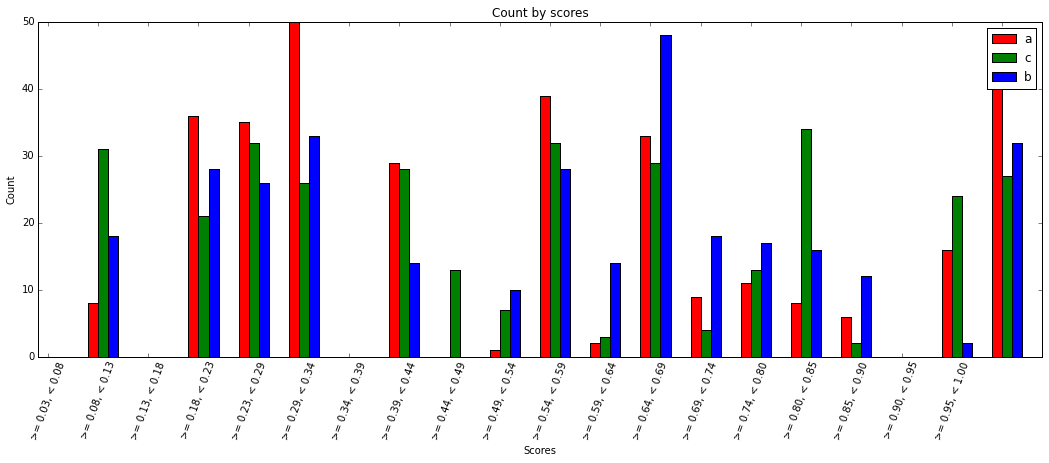

In [31]:
fig, ax = plt.subplots(figsize=(18,6))
bar_width = 0.2
colors = ['r', 'g', 'b']

for k, item in enumerate(result['series']):
    index = np.arange(len(item['data']))
    plt.bar(index + k * bar_width, 
            item['data'],
            color = colors[k],
            width = bar_width,
            label = item['label'])

plt.xlabel('Scores')
plt.ylabel('Count')
plt.title('Count by scores')
plt.xticks(index + bar_width, result['bins'], rotation=70)
plt.legend()

plt.show()
    

**Conclusion**
It has been a pretty haphazard overview of some of my favourite iterator tricks in Python. Some of the functional style, heavily influenced by Haskell has been applied too. Although it is not wise to enforce functional style in Python just for the sake of it. However, hopefully, some of the examples helped to demonstrate how readability and logical separation of the code can be improved, sometimes by effectively adding some syntactic sugar (`zip_with`, `take`), sometimes invoking deeper ideas like applicatives and monads.